In [1]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.edges.distance import *
from graphein.protein.graphs import construct_graph
from graphein.protein.visualisation import plotly_protein_structure_graph
from utils import *
from networkx import adjacency_matrix
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
from IPython.display import clear_output


edge_fns = [
    add_aromatic_interactions,
    add_hydrophobic_interactions,
    add_aromatic_sulphur_interactions,
    add_cation_pi_interactions,
    add_disulfide_interactions,
    add_hydrogen_bond_interactions,
    add_ionic_interactions,
    add_peptide_bonds
    ]
config = ProteinGraphConfig(edge_construction_functions=edge_fns)



c:\Users\HUAWEI\Desktop\materiale magistrale\CHL\CHL-Project\.venv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[05/14/24 19:43:42] WARNING  To use the Graphein submodule                                         embeddings.py:45
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             To do so, use the following command: pip install biovec                               
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[05/14/24 19:43:44] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  visualisation.py:36
                             need to install: pytorch3d                                                            
                             pytorch3d cannot be installed via pip                                                 

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        meshes.py:30
                             install: pytorch3d                                                                    
                             To do so, use the following command: pip install pytorch3d                            

In [3]:
df = generate_df(config =config)
clear_output()

In [4]:
set1 = set(df['graph_allele1'])
set2 = set(df['graph_allele2'])
set_total = set1 | set2
graphs = list(set_total)

In [5]:
len(graphs)

65

In [6]:
graphs = [g for g in graphs if g is not None]
graphs

In [7]:
adjacency_matrices = [ adjacency_matrix(graph, weight='distance') for graph in graphs]
# convert to csr_matrix
adjacency_matrices = [csr_matrix(m) for  m in adjacency_matrices]


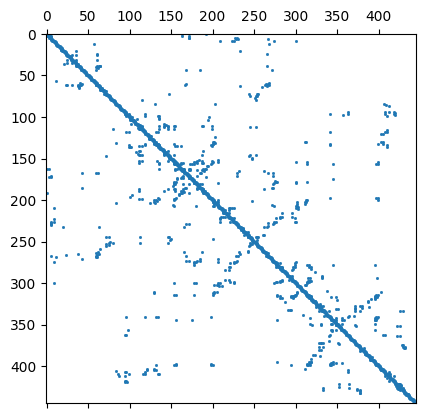

In [8]:
# spy one adjacency matrix
plt.spy(adjacency_matrices[3], ms=1)

In [9]:
nodes =list(graphs[0].nodes(data=True))


In [10]:
nodes[0][1]['coords']

array([-13.914, -21.281,   2.359])

In [11]:
def chamfer_distance(g1, g2):
    """
    Chamfer distance between two graphs
    """
    coords1 = np.array([node['coords'] for i, node in g1.nodes(data=True)])
    coords2 = np.array([node['coords'] for i, node in g2.nodes(data=True)])
    tree = KDTree(coords1)
    dist_2 = tree.query(coords2)[0]
    tree = KDTree(coords2)
    dist_1 = tree.query(coords1)[0]
    return np.mean(dist_1) + np.mean(dist_2)

In [12]:
def chamfer_matrix(graphs_list):
    n = len(graphs_list)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            M[i, j] = chamfer_distance(graphs_list[i], graphs_list[j])
            M[j, i] = M[i, j]

    return M

In [13]:
M=chamfer_matrix(graphs)

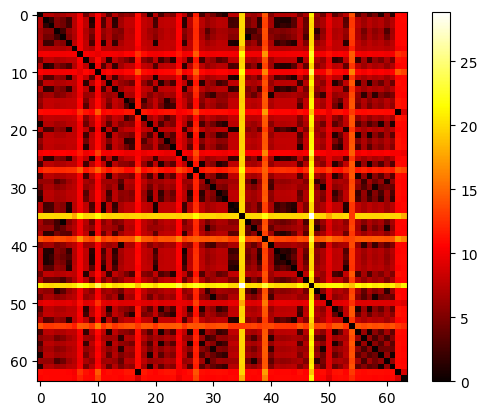

In [14]:
plt.imshow(M, cmap='hot')
plt.colorbar()
plt.show()

In [66]:
# get mean distance from other
mean_dists = M.mean(axis=1)
np.where(mean_dists>15)
# remove outliers
graphs = [g for i, g in enumerate(graphs) if mean_dists[i]<15]
M = chamfer_matrix(graphs)

In [36]:
from sklearn_extra.cluster import KMedoids

In [67]:
def silhouette_score(M, labels):
    n = len(labels)
    s = 0
    for i in range(n):
        a = np.mean([M[i, j] for j in range(n) if labels[j] == labels[i]])
        b = np.min([np.mean([M[i, j] for j in range(n) if labels[j] == k]) for k in set(labels) - {labels[i]}])
        s += (b - a) / max(a, b)
    return s / n

In [68]:
inertias=[]
silhouettes =[]
for k in range(2, 10):
    kmedoids = KMedoids(n_clusters=k, random_state=0).fit(M)
    clusters = kmedoids.labels_
    print(f'k={k}, silhouette_score={silhouette_score(M, clusters)}')
    silhouettes.append(silhouette_score(M, clusters))
    inertias.append(kmedoids.inertia_)
    print(f'k={k}, sse ={kmedoids.inertia_}')

k=2, silhouette_score=0.2958396026534504
k=2, sse =1004.4299730981528
k=3, silhouette_score=0.3428647604079399
k=3, sse =829.7833370855151
k=4, silhouette_score=0.40304940641405645
k=4, sse =574.5802525334756
k=5, silhouette_score=0.40852498486100286
k=5, sse =523.0631816459475
k=6, silhouette_score=0.4135296441963071
k=6, sse =494.9040714938401
k=7, silhouette_score=0.4135296441963071
k=7, sse =494.9040714938401
k=8, silhouette_score=0.4088586309548091
k=8, sse =488.7217282963459
k=9, silhouette_score=0.4229922223079527
k=9, sse =475.8965865270517


c:\Users\HUAWEI\Desktop\materiale magistrale\CHL\CHL-Project\.venv\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
c:\Users\HUAWEI\Desktop\materiale magistrale\CHL\CHL-Project\.venv\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
c:\Users\HUAWEI\Desktop\materiale magistrale\CHL\CHL-Project\.venv\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(


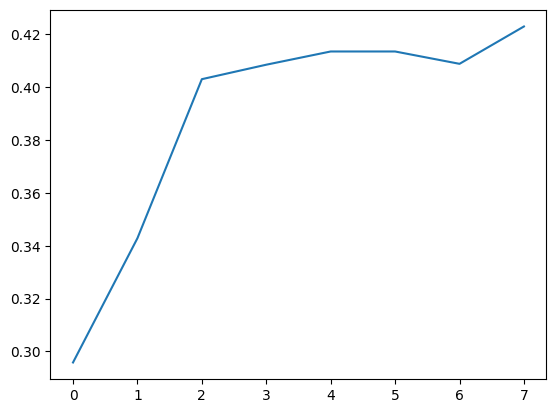

In [69]:
plt.plot(silhouettes)

In [70]:
# try again k=4

kmedoids = KMedoids(n_clusters=4, random_state=0).fit(M)


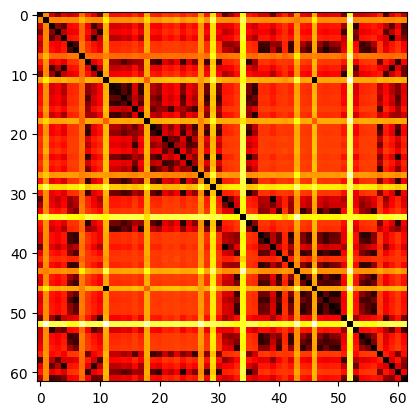

In [71]:
# reorder the graphs according to the clusters
ordered_graphs = [g for (g,_) in sorted(zip(graphs, k_medoids.labels_),  key=lambda pair: pair[1])]
ordered_graphs
chamfer_matrix_prd = chamfer_matrix(ordered_graphs)
plt.imshow(chamfer_matrix_prd, cmap='hot')

In [35]:
count =0
for node in graphs[2].nodes(data=True):
    coords1 = node[1]['coords']
    best = -1
    best_dist = 1e9
    for node2 in graphs[27].nodes(data=True):
        coords2 = node2[1]['coords']
        dist = np.linalg.norm(coords1 - coords2)
        if dist < best_dist:
            best = node2
            best_dist = dist
    if node[1]['residue_number'] != best[1]['residue_number']:
        count +=1
        print(node[1]['residue_number'], best[1]['residue_number'])
count

1 99
2 139
3 139
4 139
5 139
6 136
7 50
8 50
9 50
10 50
11 50
12 50
13 50
14 50
15 134
16 136
17 112
18 136
19 140
20 140
21 112
22 112
23 144
24 113
25 113
26 113
27 147
28 147
29 128
30 128
31 125
32 113
33 147
34 113
35 113
36 113
37 113
38 113
39 113
40 113
41 132
42 132
43 131
44 131
45 130
46 130
47 129
48 129
49 129
50 129
51 129
52 129
53 51
54 51
55 51
56 129
57 130
58 131
59 131
60 132
61 132
62 116
63 116
64 114
65 118
66 118
67 118
68 121
69 118
70 120
71 87
72 87
73 88
74 88
75 88
76 75
77 75
78 74
79 74
80 73
81 73
82 73
83 92
84 76
85 76
86 76
87 76
88 76
89 76
90 70
91 67
92 18
93 18
94 18
95 63
96 64
97 65
98 65
99 65
100 69
101 69
102 69
103 71
104 69
105 71
106 71
107 71
108 72
109 72
110 72
111 96
112 95
113 95
114 93
115 72
116 93
117 70
118 70
119 70
120 67
121 67
122 46
123 46
124 83
125 90
126 83
127 83
128 46
129 46
130 46
131 46
132 92
133 67
134 67
135 68
136 68
137 69
138 94
139 96
140 96
141 98
142 98
143 98
144 98
145 97
146 97
147 95
148 120
149 90
150 90

445

In [67]:
plotly_protein_structure_graph(graphs[2])


In [66]:
plotly_protein_structure_graph(graphs[27])